# Loading required Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy,AUC
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns  
import efficientnet.tfkeras as efn 
from tensorflow.keras.applications import MobileNetV2

C:\Users\91946\anaconda3\envs\gputest\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Image Data Augmentation

In [2]:
# making distorted data
datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        validation_split=0.2)  # randomly flip images

Declearing our Base parameters

In [3]:
data_dir = 'dataset/'
EPOCHS = 100
batch_size = 16
image_width = 128
image_hight = 128


Image Data loading With flow_from_directory method 
Spliting the data in two subfolders

In [4]:
train = datagen.flow_from_directory(data_dir,
                                    target_size=(image_width,image_hight),
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    subset='training')
val = datagen.flow_from_directory(data_dir,
                                    target_size=(image_width,image_hight),
                                    class_mode='categorical',
                                    batch_size=batch_size,
                                    subset='validation')                                   

Found 3067 images belonging to 2 classes.
Found 766 images belonging to 2 classes.


Checking for TPUs or GPUs

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


Creating a Learning Rate Schedular

Learning rate schedule: 1e-05 to 5e-05 to 1e-05


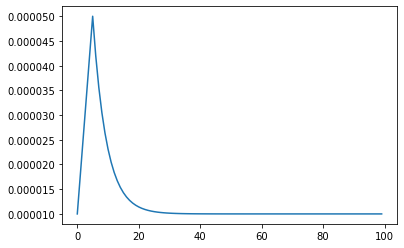

In [6]:
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# EfficientNets

Using pre trained Efficient net model for our project. 
We can also use MobilenetV2  

In [7]:

def get_model():
    with strategy.scope():
        model = tf.keras.Sequential([
            MobileNetV2(
                input_shape=(image_width,image_hight, 3),
                weights="imagenet",
                include_top=False
            ),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(2, activation='sigmoid')
        ])
        model.compile(
            optimizer='adam',
            loss = 'categorical_crossentropy',
            metrics=[tf.keras.metrics.AUC(),'accuracy'])
    
    return model

Defining callbacks and steps per epochs.
Note we have doubled our original dataset, which is being generated by ImageDataGenerator.

In [8]:
steps_per_epoch_train =  2*( len(train) // batch_size )
steps_per_epoch_val = 2* (len(val) // batch_size)

callbacks = ModelCheckpoint('saver/v2_mobilenet.h5', monitor='val_loss', verbose=2, save_best_only=True)


In [9]:
model = get_model()

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,422,210
Trainable params: 2,388,098
Non-trainable params: 34,112
_________________________________________

# Training the Model

Note we will be saving the model weights only on improvement on validation dataset.

In [11]:
history = model.fit(train,
                    steps_per_epoch= steps_per_epoch_train,
                    epochs= EPOCHS,
                    validation_data= val ,
                    validation_steps= steps_per_epoch_val,
                    callbacks=[lr_schedule, callbacks])


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24/24 [==============================] - ETA: 0s - loss: 0.9139 - auc: 0.5213 - accuracy: 0.5260WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001D61E4ACB88> and will run it as-is.
Please report this to the TensorFlow team. When filing the

C:\Users\91946\anaconda3\envs\gputest\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/24 [==============================] - ETA: 0s - loss: 0.2578 - auc: 0.9466 - accuracy: 0.9115
Epoch 00005: val_loss did not improve from 0.37660
24/24 [==============================] - 3s 121ms/step - loss: 0.2578 - auc: 0.9466 - accuracy: 0.9115 - val_loss: 0.4202 - val_auc: 0.9047 - val_accuracy: 0.8333 - lr: 4.2000e-05

Epoch 00006: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 6/100
24/24 [==============================] - ETA: 0s - loss: 0.1978 - auc: 0.9701 - accuracy: 0.9271
Epoch 00006: val_loss improved from 0.37660 to 0.17740, saving model to saver/v3_mobilenet.h5
24/24 [==============================] - 3s 119ms/step - loss: 0.1978 - auc: 0.9701 - accuracy: 0.9271 - val_loss: 0.1774 - val_auc: 0.9771 - val_accuracy: 0.9271 - lr: 5.0000e-05

Epoch 00007: LearningRateScheduler reducing learning rate to 4.2000000000000004e-05.
Epoch 7/100
24/24 [==============================] - ETA: 0s - loss: 0.1352 - auc: 0.9867 - accuracy: 0.9505
Epoch 00007: val_loss did


Epoch 00024: LearningRateScheduler reducing learning rate to 1.0720575940379282e-05.
Epoch 24/100
23/24 [===========================>..] - ETA: 0s - loss: 0.0642 - auc: 0.9962 - accuracy: 0.9755
Epoch 00024: val_loss did not improve from 0.03342
24/24 [==============================] - 3s 106ms/step - loss: 0.0663 - auc: 0.9961 - accuracy: 0.9736 - val_loss: 0.0682 - val_auc: 0.9964 - val_accuracy: 0.9792 - lr: 1.0721e-05

Epoch 00025: LearningRateScheduler reducing learning rate to 1.0576460752303425e-05.
Epoch 25/100
24/24 [==============================] - ETA: 0s - loss: 0.0438 - auc: 0.9982 - accuracy: 0.9844
Epoch 00025: val_loss improved from 0.03342 to 0.02228, saving model to saver/v3_mobilenet.h5
24/24 [==============================] - 3s 108ms/step - loss: 0.0438 - auc: 0.9982 - accuracy: 0.9844 - val_loss: 0.0223 - val_auc: 0.9998 - val_accuracy: 0.9896 - lr: 1.0576e-05

Epoch 00026: LearningRateScheduler reducing learning rate to 1.046116860184274e-05.
Epoch 26/100
24/24


Epoch 00043: LearningRateScheduler reducing learning rate to 1.0010384593717071e-05.
Epoch 43/100
24/24 [==============================] - ETA: 0s - loss: 0.0368 - auc: 0.9975 - accuracy: 0.9844
Epoch 00043: val_loss did not improve from 0.00813
24/24 [==============================] - 2s 100ms/step - loss: 0.0368 - auc: 0.9975 - accuracy: 0.9844 - val_loss: 0.0191 - val_auc: 0.9998 - val_accuracy: 0.9896 - lr: 1.0010e-05

Epoch 00044: LearningRateScheduler reducing learning rate to 1.0008307674973657e-05.
Epoch 44/100
24/24 [==============================] - ETA: 0s - loss: 0.0248 - auc: 0.9994 - accuracy: 0.9922
Epoch 00044: val_loss did not improve from 0.00813
24/24 [==============================] - 2s 89ms/step - loss: 0.0248 - auc: 0.9994 - accuracy: 0.9922 - val_loss: 0.0379 - val_auc: 0.9983 - val_accuracy: 0.9792 - lr: 1.0008e-05

Epoch 00045: LearningRateScheduler reducing learning rate to 1.0006646139978926e-05.
Epoch 45/100
24/24 [==============================] - ETA: 0s

24/24 [==============================] - ETA: 0s - loss: 0.0088 - auc: 0.9999 - accuracy: 0.9948
Epoch 00062: val_loss did not improve from 0.00119
24/24 [==============================] - 2s 85ms/step - loss: 0.0088 - auc: 0.9999 - accuracy: 0.9948 - val_loss: 0.0052 - val_auc: 1.0000 - val_accuracy: 1.0000 - lr: 1.0000e-05

Epoch 00063: LearningRateScheduler reducing learning rate to 1.000011972621413e-05.
Epoch 63/100
24/24 [==============================] - ETA: 0s - loss: 0.0121 - auc: 0.9999 - accuracy: 1.0000
Epoch 00063: val_loss did not improve from 0.00119
24/24 [==============================] - 2s 87ms/step - loss: 0.0121 - auc: 0.9999 - accuracy: 1.0000 - val_loss: 0.0038 - val_auc: 1.0000 - val_accuracy: 1.0000 - lr: 1.0000e-05

Epoch 00064: LearningRateScheduler reducing learning rate to 1.0000095780971305e-05.
Epoch 64/100
24/24 [==============================] - ETA: 0s - loss: 0.0198 - auc: 0.9997 - accuracy: 0.9947
Epoch 00064: val_loss did not improve from 0.00119
2


Epoch 00082: LearningRateScheduler reducing learning rate to 1.0000001725436587e-05.
Epoch 82/100
24/24 [==============================] - ETA: 0s - loss: 0.0215 - auc: 0.9995 - accuracy: 0.9896 ETA: 1s - loss: 0.0
Epoch 00082: val_loss did not improve from 0.00119
24/24 [==============================] - 2s 87ms/step - loss: 0.0215 - auc: 0.9995 - accuracy: 0.9896 - val_loss: 0.0014 - val_auc: 1.0000 - val_accuracy: 1.0000 - lr: 1.0000e-05

Epoch 00083: LearningRateScheduler reducing learning rate to 1.0000001380349271e-05.
Epoch 83/100
24/24 [==============================] - ETA: 0s - loss: 0.0327 - auc: 0.9989 - accuracy: 0.9870
Epoch 00083: val_loss did not improve from 0.00119
24/24 [==============================] - 2s 91ms/step - loss: 0.0327 - auc: 0.9989 - accuracy: 0.9870 - val_loss: 0.0076 - val_auc: 1.0000 - val_accuracy: 1.0000 - lr: 1.0000e-05

Epoch 00084: LearningRateScheduler reducing learning rate to 1.0000001104279416e-05.
Epoch 84/100
24/24 [======================

In [12]:
x_test = val[0][0]
y_test = val[0][1]
y_test = np.argmax(y_test,axis=1).reshape(-1,1)

In [13]:
y_pred = model.predict(x_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Determining Theshold is some times important, we can not simply go with 50-50 chances

In [14]:
x_test.shape

(16, 128, 128, 3)

In [15]:
def threshold(threshold, prediction):
    # if the prediction is confident then only it is categorized as class 1
    for i in range(len(prediction)):
        if prediction[i] > threshold:
            prediction[i] = 1
        else:
            prediction[i] = 0
    return prediction


In [16]:
y_pred = np.argmax(y_pred,axis=1).reshape(-1,1)

Here is a confusion matrix for a batch of validation_data

In [19]:
y_pred.shape

(16, 1)

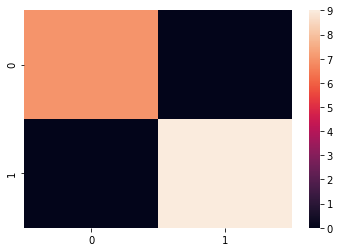

In [20]:
cm = confusion_matrix(y_test,y_pred)

sns.heatmap(cm)

Saving the model Architecture in .json format

In [21]:
model_json = model.to_json()

with open('saver/v2_mobilenet.json','w') as json_file:

    json_file.write(model_json)